In [27]:
from skimage import feature, io, color, segmentation, transform, draw, img_as_ubyte, measure, img_as_bool, filters
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.cluster import KMeans
from scipy import optimize
from skimage.morphology import disk, dilation, erosion, square, closing
from scipy import ndimage as ndi

import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from skimage.measure import label, regionprops, regionprops_table, find_contours
from skimage.transform import rotate
from sklearn.metrics import pairwise_distances_argmin
from sklearn.utils import shuffle

In [28]:
images_dir = 'Dataset/consumer'
filename = '!0BRS2FMA6I4SWH!4_5NF1STHG!LPH.JPG'

(360, 480, 3)


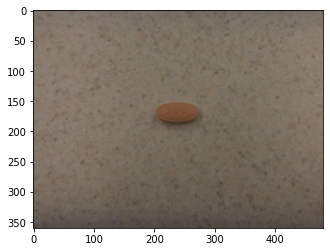

In [30]:
image_orig = io.imread(os.path.join(images_dir, filename))
# image = image_orig
image = transform.resize(image_orig, (int(image_orig.shape[0] * (480 / image_orig.shape[1])), 480), anti_aliasing=True)
#image = color.rgba2rgb(image)
plt.imshow(image)
print(image.shape)

384 480 3
Fitting model on a small sub-sample of the data
Predicting color indices on the full image (k-means)
Predicting color indices on the full image (random)


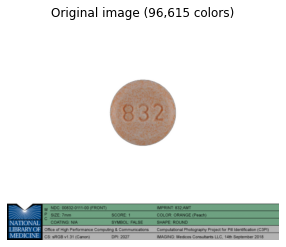

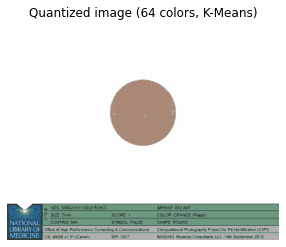

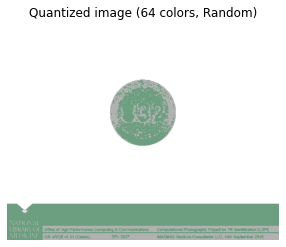

In [23]:
# K MEANS

n_colors = 6

image = np.array(image_orig, dtype=np.float64) / 255
image = transform.resize(image, (int(image_orig.shape[0] * (480 / image_orig.shape[1])), 480), anti_aliasing=True)

image = color.rgba2rgb(image)
# Load Image and transform to a 2D numpy array.
w, h, d = original_shape = tuple(image.shape)
print(w,h,d)
assert d == 3
image_array = np.reshape(image, (w * h, d))

print("Fitting model on a small sub-sample of the data")
image_array_sample = shuffle(image_array, random_state=0)[:1000]
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)

# Get labels for all points
print("Predicting color indices on the full image (k-means)")
labels = kmeans.predict(image_array)

codebook_random = shuffle(image_array, random_state=0)[:n_colors]
print("Predicting color indices on the full image (random)")

labels_random = pairwise_distances_argmin(codebook_random,
                                          image_array,
                                          axis=0)

def recreate_image(codebook, labels, w, h):
    # Recreate the (compressed) image from the code book & labels
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

# Display all results, alongside original image
plt.figure(1)
plt.clf()
plt.axis('off')
plt.title('Original image (96,615 colors)')
plt.imshow(image)

plt.figure(2)
plt.clf()
plt.axis('off')
plt.title('Quantized image (64 colors, K-Means)')
image_knn = recreate_image(kmeans.cluster_centers_, labels, w, h)
plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))

plt.figure(3)
plt.clf()
plt.axis('off')
plt.title('Quantized image (64 colors, Random)')
plt.imshow(recreate_image(codebook_random, labels_random, w, h))
plt.show()

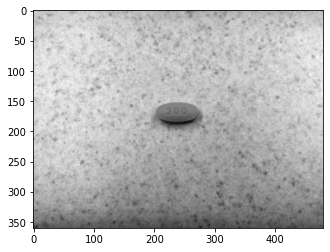

In [46]:
image_gs = color.rgb2gray(image)
plt.imshow(image_gs, cmap='gray')

[[0.45644471 0.45644471 0.45644471 ... 0.45644471 0.45644471 0.45644471]
 [0.45644471 0.45644471 0.45644471 ... 0.45644471 0.45644471 0.45644471]
 [0.45644471 0.45644471 0.45644471 ... 0.45644471 0.45644471 0.45644471]
 ...
 [0.45644471 0.45644471 0.45644471 ... 0.45644471 0.45644471 0.45644471]
 [0.45644471 0.45644471 0.45644471 ... 0.45644471 0.45644471 0.45644471]
 [0.45644471 0.45644471 0.45644471 ... 0.45644471 0.45644471 0.45644471]]


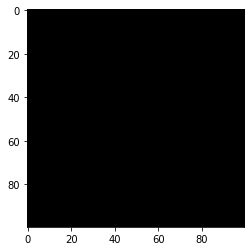

In [45]:
from skimage import io, img_as_float, filters, morphology, img_as_ubyte

a = 100
b = 100 + a
bg = img_as_float(image_gs[a:b, a:b])

bg = img_as_float(filters.rank.mean(img_as_ubyte(bg), selem=morphology.square(3)))

bg_avg = bg.copy()
bg_avg[:,:] = np.mean(bg, axis=(0,1))

print(bg_avg)

plt.imshow(bg_avg, cmap='gray')

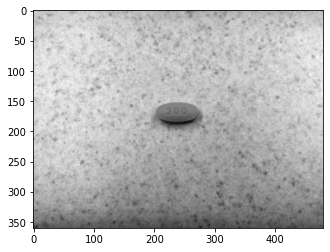

In [52]:

plt.imshow(image_gs, cmap='gray')

<Figure size 720x576 with 0 Axes>

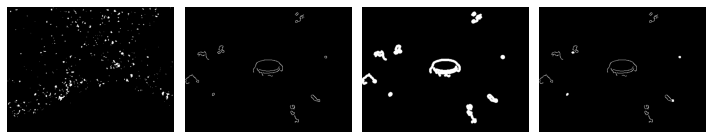

In [50]:
thresh = filters.threshold_otsu(image_gs)

bw = closing(image_gs <= thresh, square(3))

# remove artifacts connected to image border
cleared = segmentation.clear_border(bw)

# edges = filters.sobel(cleared)
edges = feature.canny(image_gs, sigma=2, low_threshold=0, high_threshold=0.1)
plt.figure(figsize=(10,8))

selem = disk(3)

dilated = dilation(edges, selem)

filled = ndi.binary_fill_holes(edges)

fig, axes = plt.subplots(1, 4, figsize=(10,10), sharey=True)
axes[0].imshow(cleared, cmap='gray')
axes[1].imshow(edges, cmap='gray')
axes[2].imshow(dilated, cmap='gray')
axes[3].imshow(filled, cmap='gray')

for a in axes:
    a.axis('off')

plt.tight_layout()

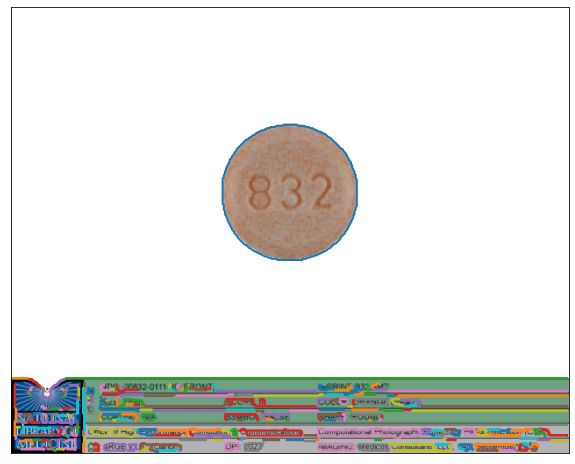

In [26]:
# Find contours at a constant value of 0.8
contours = find_contours(filled, 0.8)

# Display the image and plot all contours found
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(image, cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()